In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [3]:
transform = transforms.Compose([
  transforms.Resize(256),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

dataset = torchvision.datasets.STL10(root='./data', download=True, transform=transform, split="train")
test_dataset = torchvision.datasets.STL10(root='./data', download=True, transform=transform, split="test")
trainset, valset = torch.utils.data.random_split(dataset, [len(dataset) - 1500, 1500])

trainloader = DataLoader(trainset, batch_size=24, shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=24, shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=24, shuffle=True, num_workers=0)
dataset_sizes = {
    'train': len(dataset) - 1500,
    'valid': 1500,
    'test': len(test_dataset)
}

100%|██████████| 2640397119/2640397119 [01:29<00:00, 29473885.01it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [5]:
net = torchvision.models.wide_resnet101_2(pretrained=True)
num_ftrs = net.fc.in_features

half_in_size = round(num_ftrs/2)
layer_width = 512
Num_class=10

class STLModel(nn.Module):
  def __init__(self):
    super(STLModel, self).__init__()
    self.fc_spinal_layer1 = nn.Sequential(
        nn.Dropout(p = 0.5), nn.Linear(half_in_size, layer_width),
        nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
    self.fc_spinal_layer2 = nn.Sequential(
        nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
        nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
    self.fc_spinal_layer3 = nn.Sequential(
        nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
        nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
    self.fc_spinal_layer4 = nn.Sequential(
        nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
        nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
    self.fc_out = nn.Sequential(
        nn.Dropout(p = 0.5), nn.Linear(layer_width*4, Num_class),)

  def forward(self, x):
    x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
    x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
    x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
    x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))


    x = torch.cat([x1, x2], dim=1)
    x = torch.cat([x, x3], dim=1)
    x = torch.cat([x, x4], dim=1)


    x = self.fc_out(x)
    return x


net_fc = nn.Sequential(
  nn.Linear(512, 4096),
  nn.ReLU(inplace=True),
  nn.Dropout(),
  nn.Linear(4096, 4096),
  nn.ReLU(inplace=True),
  nn.Dropout(),
  nn.Linear(4096, Num_class)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth
100%|██████████| 243M/243M [00:09<00:00, 26.8MB/s]


In [6]:
def get_data_by_phase(phase: str):
  if phase == 'train':
    return trainloader
  if phase == 'valid':
    return valloader
  if phase == 'test':
    return testloader

In [7]:
net.fc = STLModel()

net = net.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

history = {
    'score_train': [],
    'score_test': [],
    'score_valid': [],
    'accuracy_train': [],
    'accuracy_test': [],
    'accuracy_valid': [],
    'epochs': [],
}

since = time.time()

best_model_wts = copy.deepcopy(net.state_dict())
best_acc = 0.0
test_token=0

for epoch in range(30):
    print('Epoch {}/{}'.format(epoch, 30))
    print('-' * 10)
    history['epochs'].append(epoch)

    for phase in ['train', 'valid', 'test']:
        if test_token ==0 and phase == 'test':
            continue
        test_token =0


        if phase == 'train':
            net.train()
        else:
            net.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in get_data_by_phase(phase):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            exp_lr_scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

        if phase == 'valid' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(net.state_dict())
            test_token =1
        y_pred = []
        y_true = []
        with torch.no_grad():
          for inputs, labels in get_data_by_phase(phase):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
        accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred, average='macro')
        precision = precision_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        history[f'score_{phase}'].append(accuracy)
        history[f'accuracy_{phase}'].append(f1)

    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

net.load_state_dict(best_model_wts)

print('ඞ ඞ ඞ ඞ ඞ ඞ ඞ')

Epoch 0/30
----------
train Loss: 1.2809 Acc: 0.6306
valid Loss: 0.2526 Acc: 0.9680
test Loss: 0.2448 Acc: 0.9718

Epoch 1/30
----------
train Loss: 0.3016 Acc: 0.9343
valid Loss: 0.1084 Acc: 0.9780
test Loss: 0.0970 Acc: 0.9771

Epoch 2/30
----------
train Loss: 0.1563 Acc: 0.9669
valid Loss: 0.0776 Acc: 0.9800
test Loss: 0.0688 Acc: 0.9828

Epoch 3/30
----------
train Loss: 0.0988 Acc: 0.9771
valid Loss: 0.0666 Acc: 0.9807
test Loss: 0.0625 Acc: 0.9825

Epoch 4/30
----------
train Loss: 0.0694 Acc: 0.9849
valid Loss: 0.0601 Acc: 0.9813
test Loss: 0.0554 Acc: 0.9845

Epoch 5/30
----------
train Loss: 0.0485 Acc: 0.9911
valid Loss: 0.0593 Acc: 0.9827
test Loss: 0.0561 Acc: 0.9830

Epoch 6/30
----------
train Loss: 0.0356 Acc: 0.9954
valid Loss: 0.0523 Acc: 0.9840
test Loss: 0.0548 Acc: 0.9841

Epoch 7/30
----------
train Loss: 0.0349 Acc: 0.9946
valid Loss: 0.0492 Acc: 0.9847
test Loss: 0.0525 Acc: 0.9840

Epoch 8/30
----------
train Loss: 0.0401 Acc: 0.9923
valid Loss: 0.0632 Acc: 0.9

KeyboardInterrupt: ignored

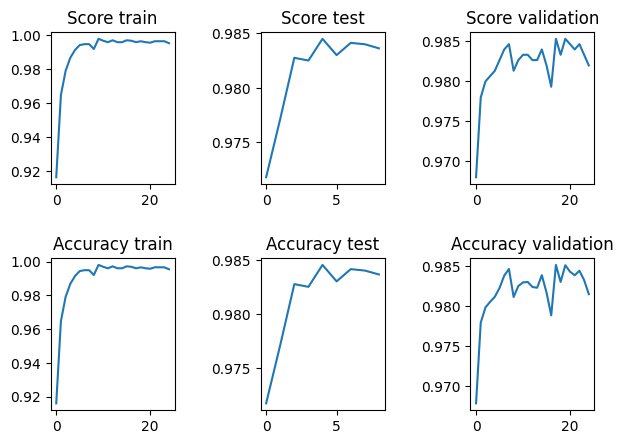

In [14]:
fig, ax = plt.subplots(2, 3)

ax[0, 0].plot(history['epochs'][:len(history['score_train'])], history['score_train'])
ax[0, 0].set_title('Score train')

ax[0, 1].plot(history['epochs'][:len(history['score_test'])], history['score_test'])
ax[0, 1].set_title('Score test')

ax[0, 2].plot(history['epochs'][:len(history['score_valid'])], history['score_valid'])
ax[0, 2].set_title('Score validation')

ax[1, 0].plot(history['epochs'][:len(history['accuracy_train'])], history['accuracy_train'])
ax[1, 0].set_title('Accuracy train')

ax[1, 1].plot(history['epochs'][:len(history['accuracy_test'])], history['accuracy_test'])
ax[1, 1].set_title('Accuracy test')

ax[1, 2].plot(history['epochs'][:len(history['accuracy_valid'])], history['accuracy_valid'])
ax[1, 2].set_title('Accuracy validation')


fig.tight_layout(pad=2.0)

plt.show()